In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from ipywidgets import interact, fixed
import cv2
from skimage.color import gray2rgb
from skimage.filters import threshold_local, threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing
#from pyprind import prog_percent
from glob import glob
import pandas as pd
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte
import os

import seaborn as sns
sns.set(style='ticks', palette='deep')


array([[ 8, 32, 82, ..., 16, 33,  9],
       [45, 86, 50, ..., 98, 74, 76],
       [92,  7, 48, ..., 97, 92, 39],
       ..., 
       [54, 42, 61, ..., 26, 30, 66],
       [ 3, 77, 86, ..., 52, 98,  9],
       [21, 17, 74, ..., 84, 17, 36]])

In [14]:
frame = np.random.randint(0,100, (2000,2000))
cv2.threshold(frame, 5, 255, cv2.THRESH_BINARY)

error: /tmp/opencv-3.2.0/modules/imgproc/src/thresh.cpp:1431: error: (-210)  in function threshold


In [16]:
frame = cv2.imread('/Users/luigipetrucco/Desktop/eyes_good_files/000001.tif')

<IPython.core.display.Javascript object>


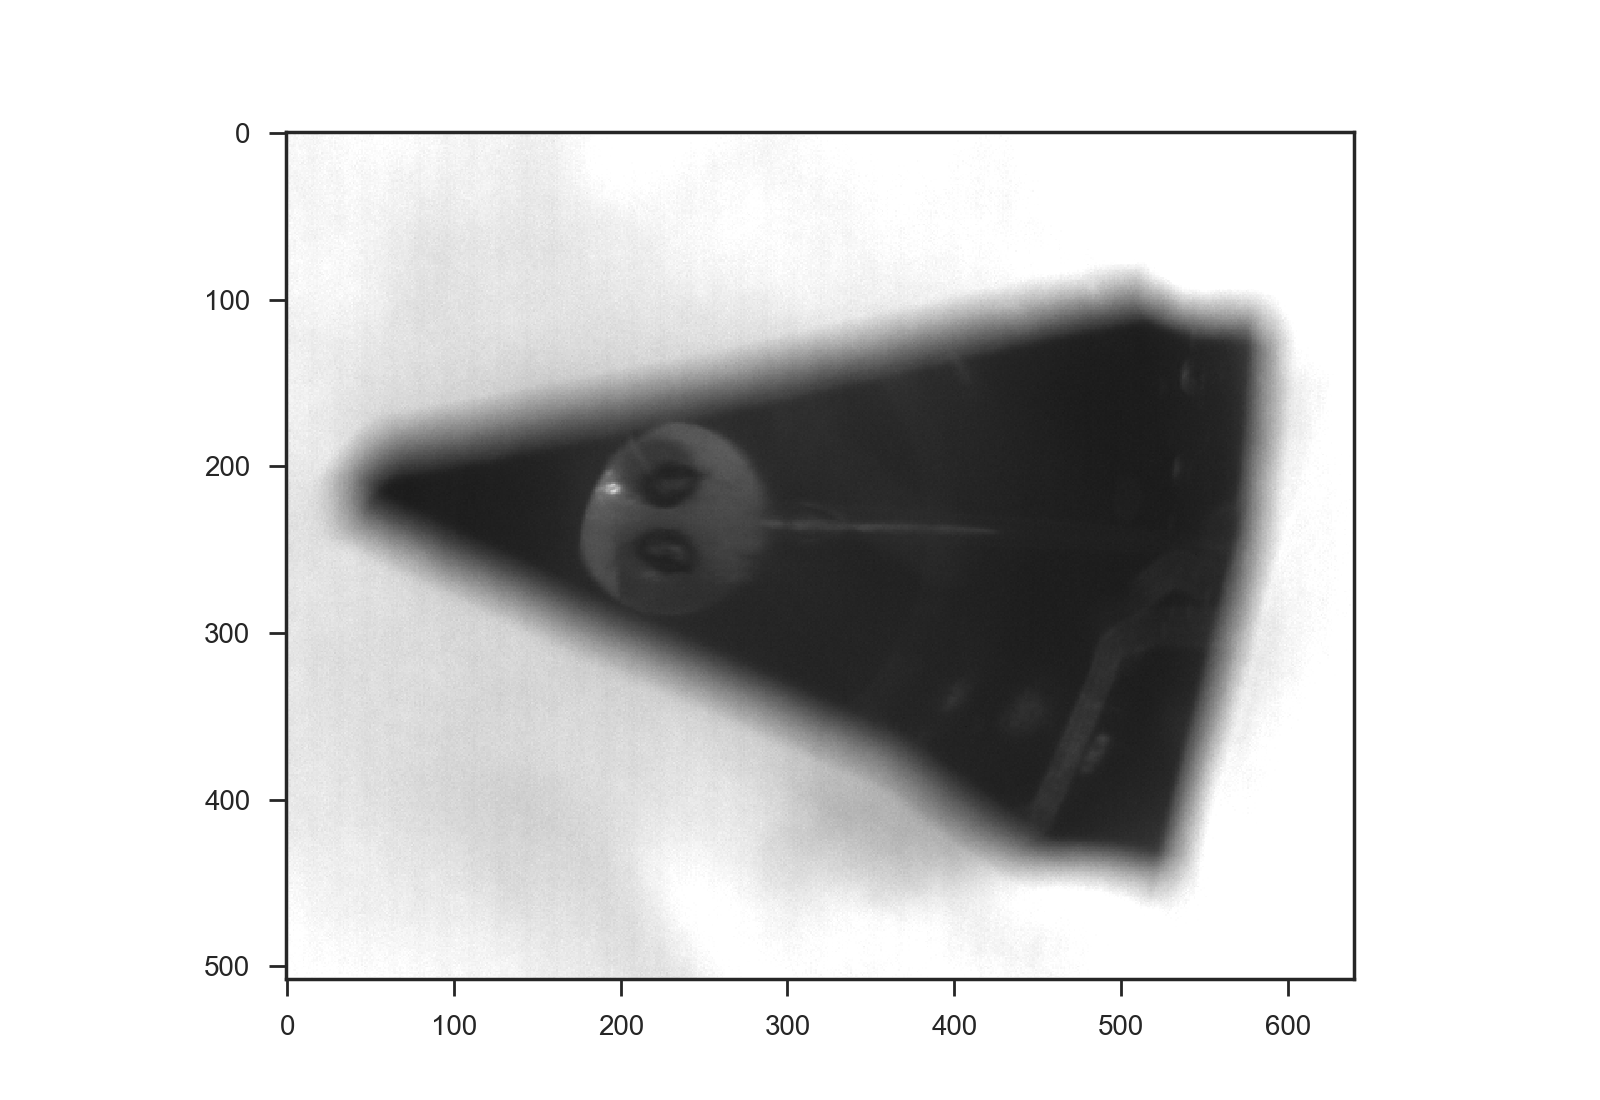

In [17]:
plt.imshow(frame)

In [ ]:
fram

In [2]:
def loadMovie(fn, transpose=True):
    frames = []
    c = cv2.VideoCapture(fn)
    
    while True:
        flag, im = c.read()
        
        if flag:
            frames.append(im[...,0] if not transpose else im[...,0].T)
            
        else:
            break
            
    print(len(frames), 'frames were loaded.')
    return np.array(frames)

def testThreshold(mov):
    @interact
    def t(mov=fixed(mov), frame:(0, len(mov))=0, threshold=(0,255), invert=False, fit_eyes=False):
        im = mov[frame]
        
        if fit_eyes:
            e = fitEllipse((im > threshold))
            ime = drawEllipse(gray2rgb(im), e)
            plt.imshow(ime)
            
        else:
            plt.imshow(im > threshold if invert == False else im < threshold)
            
def threshold_local_interactive(mov):
    @interact
    def tli(mov=fixed(mov), frame:(0, len(mov))=0, block_size:(3,77,2)=17, offset:(1,100)=70, fit_eyes=False):
        t = mov[frame] > threshold_local(mov[frame], block_size=block_size, offset=offset)
        
        if fit_eyes:
            e = fitEllipse(t)
            ime = drawEllipse(gray2rgb(mov[frame]), e)
            plt.imshow(ime)
            
        else:
            plt.imshow(t)


def pad(im, padding=0, val=0):
    padded = np.lib.pad(im, ((padding,padding),(padding,padding)), mode='constant', constant_values=((val, val),(val, val)))
    return padded


def local(im, padding=2, block_size=17, offset=70):
    padded = np.lib.pad(im, ((padding,padding),(padding,padding)), mode='constant', constant_values=((im.min(), im.min()),(im.min(), im.min())))
    return padded > threshold_local(padded, block_size=block_size, offset=offset)


def fitEllipse(t):
    _, contours, hierarchy = cv2.findContours(t.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    e = []

    if len(contours) >= 2:
        contours = sorted(contours, key=lambda c: c.shape[0], reverse=True)[:2]
        contours = sorted(contours, key=np.max)

        for i in range(2):
            c = contours[i]

            try:
                ellipse = cv2.fitEllipse(c)

                e.append(ellipse)

            except:
                print('Failed...')
                pass#e = False

        return e

    else:
        return False


def fitEllipse(t):
    _, contours, hierarchy = cv2.findContours(t.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    e = []

    if len(contours) >= 2:
        contours = sorted(contours, key=lambda c: c.shape[0], reverse=True)[:2]
        contours = sorted(contours, key=np.max)

        for i in range(2):
            c = contours[i]

            try:
                ellipse = cv2.fitEllipse(c)

                e.append(ellipse)

            except:
                print('Failed...')
                pass#e = False

        return e

    else:
        return False


def drawEllipse(im, e, c=None):
    imc = im.copy()

    if c is None:
        c = [(255,0,255, 255), (20,255,20, 255), (20,255,20, 255), (20,255,20, 255)]
    
    else:
        assert len(e)==len(c), 'There are not as many colors as ellipses to be drawn!'

    for i, eye in enumerate(e):
        cv2.ellipse(imc, eye, c[i], 1)
        
    return imc

# Try different methods

In [35]:
def loadMovie(fn, transpose=True, frames_n=None, xlims=None, ylims=None):
    frames = []
    if fn.split('.')[-1] == 'xiseq':
        print('sequence')
        frames_fn = glob('{}_files/*'.format(fn.split('.')[-2]))
        frames_fn.sort()
        frame1 = cv2.imread(frames_fn[0])
        print(frame1.shape)
        
        if frames_n is None:
            frames_n = len(frames_fn)
        if xlims is None:
            xlims = (0, frame1.shape[0])
        if ylims is None:
            ylims = (0, frame1.shape[1])
            
        frames = np.zeros((len(frames_fn), xlims[1] - xlims[0], ylims[1] - ylims[0]))
        
        for i, n in enumerate(frames_fn[:frames_n]):
            if np.mod(i, 500) == 0:
                print('{}...'.format(i))
            try:
                frames[i, :, :] = cv2.imread(n)[slice(*xlims), slice(*ylims), 0]
            except TypeError:
                print('wrong loading: {}'.format(i))

    else:
        c = cv2.VideoCapture(fn)

        while True:
            flag, im = c.read()

            if flag:
                frames.append(im[...,0] if not transpose else im[...,0].T)

            else:
                break
        
        print(len(frames), 'frames were loaded.')
    return frames

In [101]:
glob(r'J:\_Shared\lightsheet testing\eye_tracking\eyes_better_files/*')

['J:\\_Shared\\lightsheet testing\\eye_tracking\\eyes_better_files\\008028.tif',
 'J:\\_Shared\\lightsheet testing\\eye_tracking\\eyes_better_files\\004774.tif',
 'J:\\_Shared\\lightsheet testing\\eye_tracking\\eyes_better_files\\004507.tif',
 'J:\\_Shared\\lightsheet testing\\eye_tracking\\eyes_better_files\\008082.tif',
 'J:\\_Shared\\lightsheet testing\\eye_tracking\\eyes_better_files\\004943.tif',
 'J:\\_Shared\\lightsheet testing\\eye_tracking\\eyes_better_files\\000405.tif',
 'J:\\_Shared\\lightsheet testing\\eye_tracking\\eyes_better_files\\001561.tif',
 'J:\\_Shared\\lightsheet testing\\eye_tracking\\eyes_better_files\\008345.tif',
 'J:\\_Shared\\lightsheet testing\\eye_tracking\\eyes_better_files\\005077.tif',
 'J:\\_Shared\\lightsheet testing\\eye_tracking\\eyes_better_files\\001230.tif',
 'J:\\_Shared\\lightsheet testing\\eye_tracking\\eyes_better_files\\000908.tif',
 'J:\\_Shared\\lightsheet testing\\eye_tracking\\eyes_better_files\\009520.tif',
 'J:\\_Shared\\lightsheet te

In [36]:
source_file = r'J:\_Shared\lightsheet testing\eye_tracking\eyes_better.xiseq'
full_mov = loadMovie(source_file, transpose=True, frames_n=None, xlims=(140, 250), ylims=(200, 260))

sequence
(508, 640, 3)
0...
500...
1000...
1500...
2000...
2500...
3000...
3500...
4000...
4500...
5000...
5500...
6000...
6500...
7000...
7500...
8000...
8500...
9000...
9500...
wrong loading: 9577


<IPython.core.display.Javascript object>


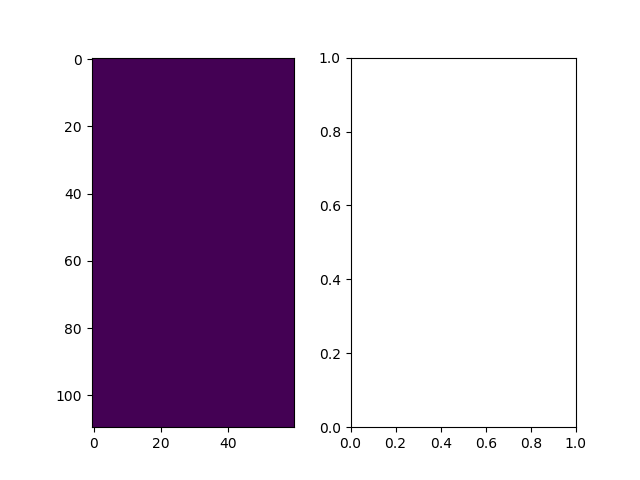

In [32]:
xlims = (140, 250)
ylims = (200, 260)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(full_mov[10, :, :])
plt.subplot(1,2,2)
# plt.imshow(full_mov[0, slice(*xlims), slice(*ylims)])

In [40]:
mov = full_mov#[:, slice(*xlims), slice(*ylims)]

<IPython.core.display.Javascript object>


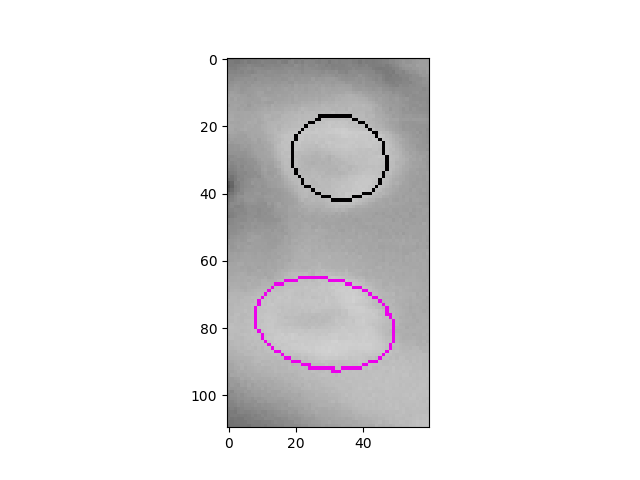

A Jupyter Widget

In [41]:
plt.figure()
testThreshold(mov[:, :, :])

<IPython.core.display.Javascript object>


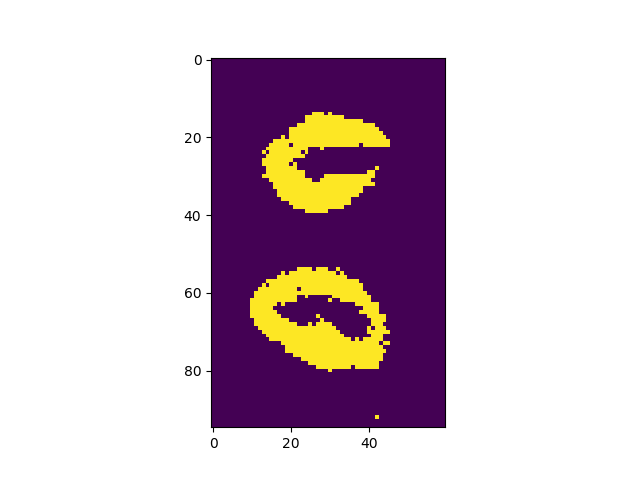

In [12]:
plt.figure()
plt.imshow((-mov[0, :, :] > -44))

In [59]:
left, right = [], []

for i in range(mov.shape[0]):
    if np.mod(i, 500) == 0:
        print(i)
    e = fitEllipse((-mov[i, :, :] > -65).copy())

    if e is not False:
        left.append(e[0][2])
        right.append(e[1][2])
    else:
        left.append(np.nan)
        right.append(np.nan)

left = np.array(left)
right = np.array(right)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [63]:
left.shape

(9578,)

<IPython.core.display.Javascript object>


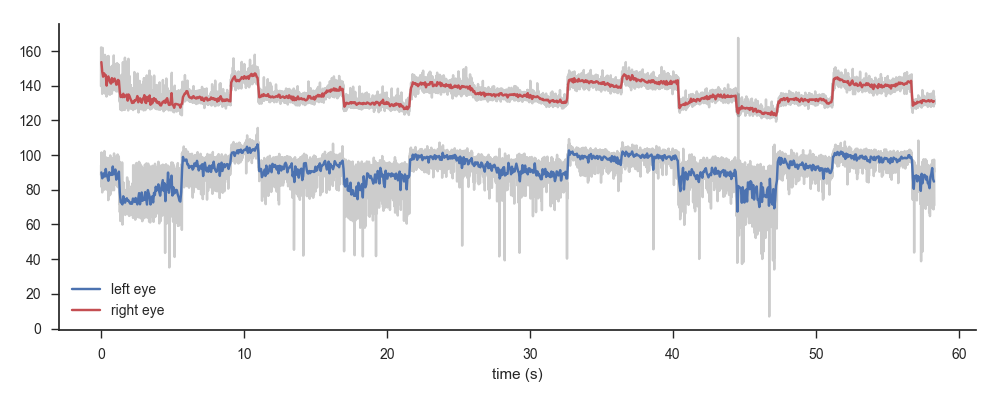

In [98]:
cols = sns.color_palette()
t = np.arange(left.shape[0])/163
plt.figure(figsize=(10, 4))
# plt.plot(left)
# plt.plot(right)

end = 9500
dwn = 10
plt.plot(t[:end], left[:end], alpha=0.2, c='k')
plt.plot(t[:end], right[:end] +40, alpha=0.2, c='k')
# plt.plot(right[:end].reshape(20, ))

plt.plot(t[:end].reshape(int(end/dwn), dwn).mean(1), left[:end].reshape(int(end/dwn), dwn).mean(1), label='left eye')
plt.plot(t[:end].reshape(int(end/dwn), dwn).mean(1), right[:end].reshape(int(end/dwn), dwn).mean(1)+40, c=cols[2], label='right eye')
# plt.plot(right[:end].reshape(20))
plt.xlabel('time (s)')
plt.legend()
sns.despine()
plt.tight_layout()

<IPython.core.display.Javascript object>


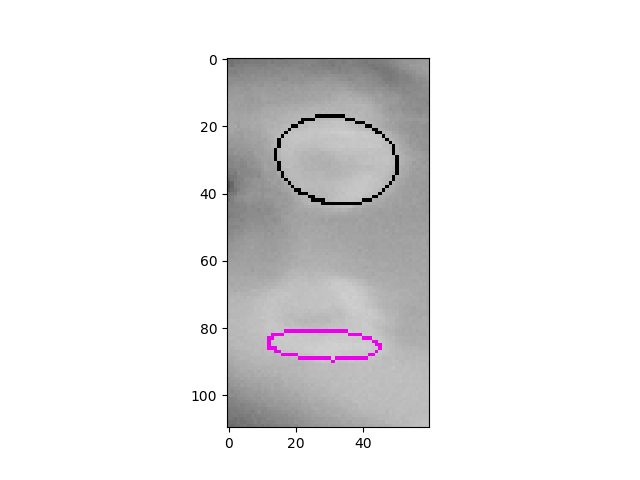

A Jupyter Widget

In [55]:
plt.figure()
threshold_local_interactive(mov[:, :, :])

In [56]:
def track(frame):
    return local(frame, 0, 45, 9)

left, right = [], []

for i in range(mov.shape[0]):
    t = track(mov[i])
    e = fitEllipse(t.copy()*255)

    if e is not False:
        left.append(e[0][2])
        right.append(e[1][2])
    else:
        left.append(np.nan)
        right.append(np.nan)
    
    

left = np.array(left)
right = np.array(right)

<IPython.core.display.Javascript object>


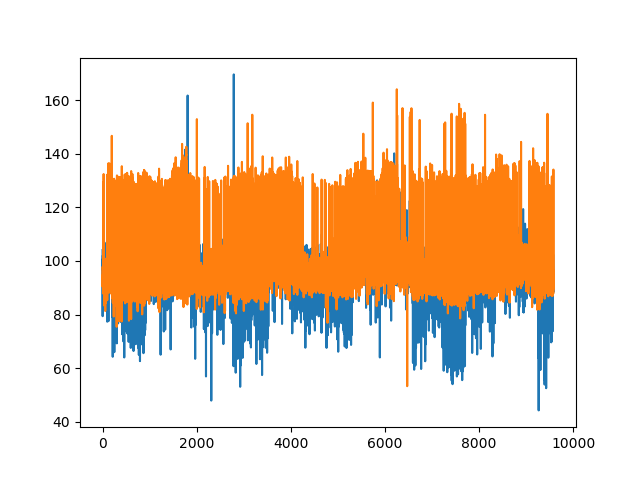

In [57]:
plt.figure()
plt.plot(left)
plt.plot(right)

<IPython.core.display.Javascript object>


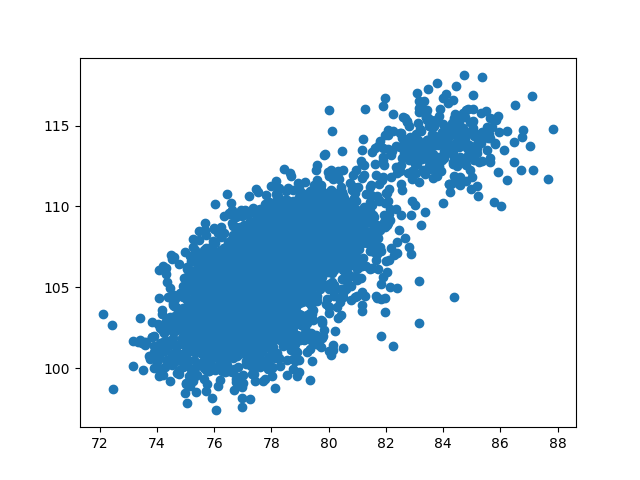

In [26]:
plt.figure()
plt.scatter(left, right)

[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:00:00


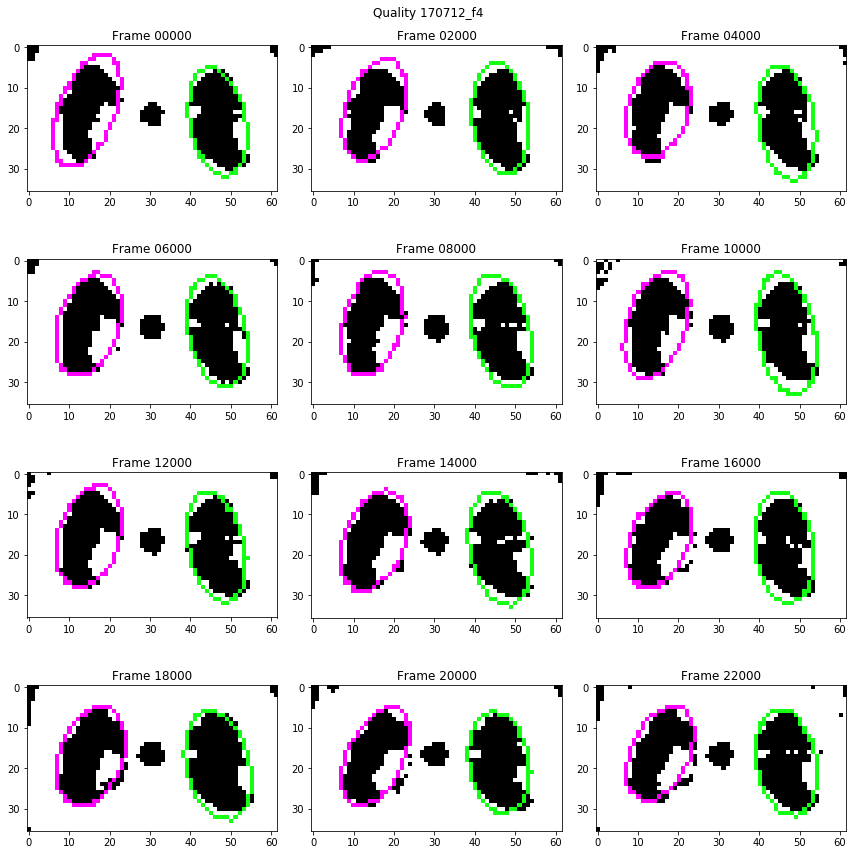

In [94]:
plt.figure(figsize=(12,12))
c=1

for i in prog_percent(range(0,mov.shape[0],2000)):
    t = track_170712_f4(mov[i])
    e = fitEllipse(t.copy()*255)
    imgd = drawEllipse(gray2rgb(t.astype(np.uint8)*255), e)
    
    plt.subplot(4,3,c)
    plt.imshow(imgd)
    plt.title('Frame {:05d}'.format(i))
    
    c += 1
    
plt.suptitle('Quality {}'.format(exp), y=1.0)
plt.tight_layout()
plt.savefig(DESTINATION_EXP+'{}_quality.png'.format(exp), bbox_inches='tight')

In [95]:
left, right = [], []

for i in range(0,mov.shape[0]):
    t = track_170712_f4(mov[i])
    e = fitEllipse(t.copy()*255)

    left.append(e[0][2])
    right.append(e[1][2])

left = np.array(left)
right = np.array(right)

left[left>90] -= 180
right[right>90] -= 180


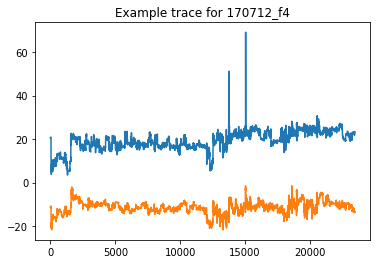

In [96]:
plt.plot(left, label='left eye')
plt.plot(right, label='right eye')
plt.title('Example trace for {}'.format(exp))
plt.savefig(DESTINATION_EXP+'{}_example_trace.png'.format(exp), dpi=300)

# Run experiment!

In [98]:
new_time = np.arange(0, 119.5 * 1000, 5)

In [99]:
movies = sorted(glob(r'J:\Daniil Markov\Rita_Daniil_OMR\data\{}\{}_be\*eyes.avi'.format(exp, exp)))

total_left = []
total_right = []
total_left_interp = []
total_right_interp = []


for fn in prog_percent(movies):
    mov = loadMovie(fn)
    
    left, right = [], []

    for i in range(0,mov.shape[0]):
        t = track_170712_f4(mov[i])
        e = fitEllipse(t.copy()*255)

        left.append(e[0][2])
        right.append(e[1][2])

    left = np.array(left)
    right = np.array(right)

    left[left>90] -= 180
    right[right>90] -= 180

    data = np.load(fn.replace('_eyes.avi','_data.npy'))
    old_time = data[:,0] - data[0,0]
    
    left_interp = np.interp(new_time, old_time, left)
    right_interp = np.interp(new_time, old_time, right)
    
    total_left_interp.append(left_interp)
    total_right_interp.append(right_interp)
    
    total_left.append(left)
    total_right.append(right)

23457 frames were loaded.


[  4 %] Time elapsed: 00:00:12 | ETA: 00:05:03

23315 frames were loaded.


[  8 %] Time elapsed: 00:00:25 | ETA: 00:04:56

23446 frames were loaded.


[ 12 %] Time elapsed: 00:00:38 | ETA: 00:04:43

23429 frames were loaded.


[ 16 %] Time elapsed: 00:00:51 | ETA: 00:04:31

23283 frames were loaded.


[ 20 %] Time elapsed: 00:01:04 | ETA: 00:04:17

23250 frames were loaded.


[ 24 %] Time elapsed: 00:01:17 | ETA: 00:04:03

23518 frames were loaded.


[ 28 %] Time elapsed: 00:01:29 | ETA: 00:03:51

23592 frames were loaded.


[ 32 %] Time elapsed: 00:01:42 | ETA: 00:03:38

23567 frames were loaded.


[ 36 %] Time elapsed: 00:01:59 | ETA: 00:03:32

23498 frames were loaded.


[ 40 %] Time elapsed: 00:02:18 | ETA: 00:03:28

23401 frames were loaded.


[ 44 %] Time elapsed: 00:02:36 | ETA: 00:03:19

23522 frames were loaded.


[ 48 %] Time elapsed: 00:02:49 | ETA: 00:03:03

23496 frames were loaded.


[ 52 %] Time elapsed: 00:03:02 | ETA: 00:02:48

23513 frames were loaded.


[ 56 %] Time elapsed: 00:03:14 | ETA: 00:02:33

23442 frames were loaded.


[ 60 %] Time elapsed: 00:03:27 | ETA: 00:02:18

23428 frames were loaded.


[ 64 %] Time elapsed: 00:03:40 | ETA: 00:02:04

23472 frames were loaded.


[ 68 %] Time elapsed: 00:03:53 | ETA: 00:01:49

23502 frames were loaded.


[ 72 %] Time elapsed: 00:04:06 | ETA: 00:01:36

23495 frames were loaded.


[ 76 %] Time elapsed: 00:04:25 | ETA: 00:01:23

23513 frames were loaded.


[ 80 %] Time elapsed: 00:04:38 | ETA: 00:01:09

23435 frames were loaded.


[ 84 %] Time elapsed: 00:04:52 | ETA: 00:00:55

23502 frames were loaded.


[ 88 %] Time elapsed: 00:05:05 | ETA: 00:00:41

23486 frames were loaded.


[ 92 %] Time elapsed: 00:05:18 | ETA: 00:00:27

23509 frames were loaded.


[ 96 %] Time elapsed: 00:05:31 | ETA: 00:00:13

23519 frames were loaded.


[100 %] Time elapsed: 00:05:44 | ETA: 00:00:00
Total time elapsed: 00:05:44


In [100]:
plane = 0

for i, j in zip(total_left, total_right):
    df = pd.DataFrame([i, j]).T
    df.columns = 'left_eye', 'right_eye'
    df.index.name = 'frame'
    
    name_base = movies[plane].split('\\')[-1]
    
    df.to_csv(DESTINATION_EXP+'{}'.format(name_base.replace('.avi','_not_interpolated.csv')))
    plane += 1

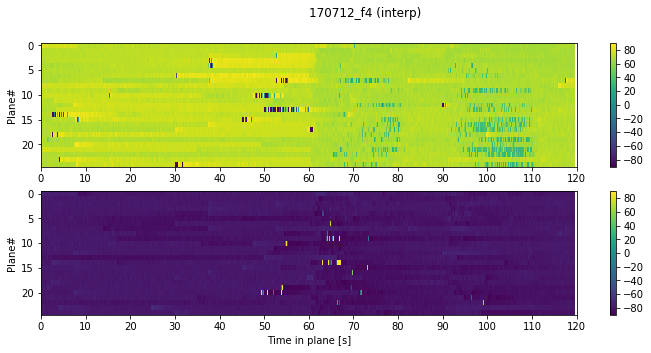

In [101]:
plt.figure(figsize=(12,5))
plt.subplot(211)
plt.imshow(total_left_interp,aspect='auto')
plt.xticks(np.arange(13)*2000, np.arange(13)*10)
plt.colorbar()
plt.ylabel('Plane#')
plt.subplot(212)
plt.imshow(total_right_interp,aspect='auto')
plt.xticks(np.arange(13)*2000, np.arange(13)*10)
plt.colorbar()
plt.ylabel('Plane#')
plt.xlabel('Time in plane [s]')
plt.suptitle('{} (interp)'.format(exp))

plt.savefig(DESTINATION_EXP+'{}_eyes_overview.png'.format(exp),dpi=300)